In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import random
from tqdm import tqdm
import numpy as np
from GRUnet import InitGRU, KalmanNetNN

Importing dataset took 15.145029783248901 seconds
Number of all 0 columns: 0
Running EM algorithm...


EM iteration:  15%|███▌                    | 292/2000 [14:36<1:20:07,  2.81s/it]

Error: Data likelihood has decreased from 195551.49791242342 to 195090.29549154098 



/Users/leskywalker/Documents/EE689/project/Code/EM.py:179: RuntimeWarning: invalid value encountered in log
  term3 = -0.5 * np.log(det_K)
EM iteration:  16%|███▋                    | 312/2000 [15:33<1:17:41,  2.76s/it]/Users/leskywalker/Documents/EE689/project/Code/EM.py:178: RuntimeWarning: invalid value encountered in log
  term1 = -0.5 * T * np.log(det_R)
EM iteration:  16%|███▊                    | 322/2000 [16:02<1:23:36,  2.99s/it]

Error: Data likelihood has decreased from 199655.37163709447 to 199050.13745538244 



EM iteration:  18%|████▎                   | 357/2000 [17:44<1:16:17,  2.79s/it]

Error: Data likelihood has decreased from 199575.1784013099 to 199569.2641769659 



EM iteration:  18%|████▎                   | 363/2000 [18:02<1:22:42,  3.03s/it]

Error: Data likelihood has decreased from 200158.06185081115 to 199808.53574202914 



EM iteration:  18%|████▎                   | 364/2000 [18:05<1:24:04,  3.08s/it]

Error: Data likelihood has decreased from 199808.53574202914 to 198255.19093879423 



EM iteration:  18%|████▍                   | 369/2000 [18:21<1:25:59,  3.16s/it]

Error: Data likelihood has decreased from 200458.64034207867 to 199383.92347213835 



EM iteration:  18%|████▍                   | 370/2000 [18:25<1:35:23,  3.51s/it]

Error: Data likelihood has decreased from 199383.92347213835 to 198785.78368780727 



EM iteration:  19%|████▍                   | 371/2000 [18:28<1:29:24,  3.29s/it]

Error: Data likelihood has decreased from 198785.78368780727 to 198115.93272930325 



EM iteration:  29%|██████▉                 | 575/2000 [28:49<1:13:20,  3.09s/it]

Error: Data likelihood has decreased from 173176.4582172521 to 170197.93735058833 



EM iteration:  40%|████████▉             | 808/2000 [1:05:26<1:03:37,  3.20s/it]

Error: Data likelihood has decreased from 190981.01979323692 to 189277.11496002783 



EM iteration:  41%|█████████▊              | 813/2000 [1:05:41<59:05,  2.99s/it]

Error: Data likelihood has decreased from 190958.39221317883 to 189543.60361241028 



EM iteration:  41%|█████████▊              | 814/2000 [1:05:44<58:09,  2.94s/it]/Users/leskywalker/Documents/EE689/project/Code/EM.py:181: RuntimeWarning: invalid value encountered in log
  term5 = -0.5 * (T - 1) * np.log(det_Q)
EM iteration:  44%|██████████▌             | 885/2000 [1:09:23<55:14,  2.97s/it]/Users/leskywalker/anaconda3/envs/ee689/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
EM iteration: 100%|███████████████████████| 2000/2000 [2:07:16<00:00,  3.82s/it]


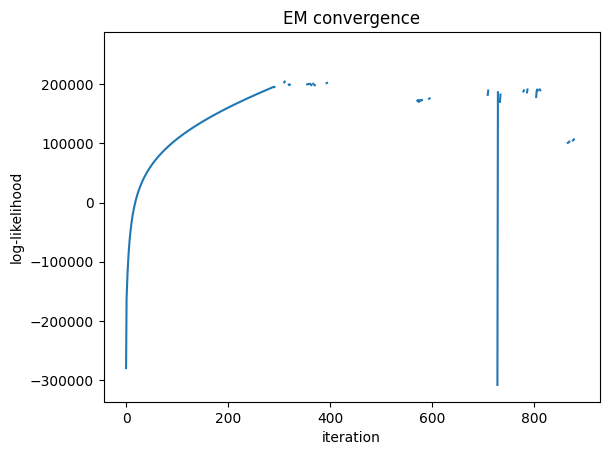

EM algorithm finished in 7636.086703777313 seconds
Calculating Latent States...
Prediction finished in 0.6170759201049805 seconds
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...


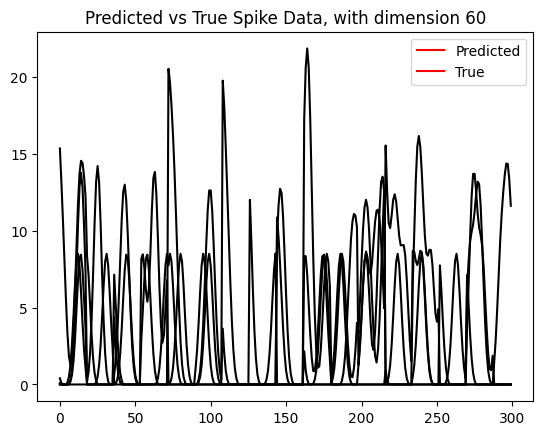

Calculating Latent States...
Prediction finished in 2.2283856868743896 seconds


ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/leskywalker/anaconda3/envs/ee689/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/leskywalker/anaconda3/envs/ee689/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leskywalker/anaconda3/envs/ee689/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py", line 1123, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/leskywalker/anaconda3/envs/ee689/lib/python3.11/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leskywalker/anaconda3/envs/ee689/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1146, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/leskywalker/anaconda3/envs/ee689/lib/python3.11/site-packages/sklearn/utils/validation.py", line 957, in check_array
    _assert_all_finite(
  File "/Users/leskywalker/anaconda3/envs/ee689/lib/python3.11/site-packages/sklearn/utils/validation.py", line 122, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/leskywalker/anaconda3/envs/ee689/lib/python3.11/site-packages/sklearn/utils/validation.py", line 171, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from util import import_dataset, get_spikes_and_velocity, pre_process_spike, get_surrogate_data, plot_hand_trajectory
from EM import em_core

if __name__ == '__main__':
    train_dataset = import_dataset('Jenkins_train.nwb')

    train_spikes, train_velocity = get_spikes_and_velocity(train_dataset, resample_size=5, smooth=True)


    train_spikes, train_velocity = pre_process_spike(train_spikes, train_velocity, train_dataset,
                                                     window_step=5, overlap=True, window_size=15, smooth=False)

    trial_type = train_dataset.trial_info.set_index('trial_type').index.tolist()

    # TODO: Examine the PSTHs

    # TODO: Plot PSTHs

    # Calculate EM #TODO: TEMPORARY CODE
    # 1) Generate surrogate data
    # 2) Run EM
    # 3) Predict latent states
    # 4) Predict hand velocity

    X, X_test, Y, Y_test, X_label, X_test_label = get_surrogate_data(train_spikes, train_velocity, trial_type, trials=100)

    # Run EM
    mses = []

    EM_class = em_core(X, n_dim=60, n_iters=2000)
    EM_class.get_parameters(plot=True)

    # TODO: Calculate Latent States for training data and plot to see grouping

    # Predict latent states
    latent_states = EM_class.cal_latent_states(X_test, current=False)

    # One step ahead prediction for spike data
    back_predict = np.array([EM_class.get_one_step_ahead_prediction(latent_states[i])
                             for i in range(len(latent_states))])

    # Combine all trials for back_predict and X_test
    back_predict_con = np.array([back_predict[i] for i in range(len(back_predict))])
    back_predict_con = back_predict_con.reshape(-1, back_predict_con.shape[-1])
    X_test_con = np.array([X_test[i] for i in range(len(X_test))])
    X_test_con = X_test_con.reshape(-1, X_test_con.shape[-1])

    # Plot back_predict and True value
    plt.figure()
    plt.plot(back_predict_con[:300, 0:5], label='Predicted', color='red')
    plt.plot(X_test_con[:300, 0:5], label='True', color='black')
    plt.title('Predicted vs True Spike Data, with dimension ' + str(EM_class.n_dim))
    plt.legend(['Predicted', 'True'])
    plt.show()

    EM_class.fit(X, Y)

    # Predict the hand velocity
    hand_velocity = np.array([EM_class.predict_move(X_test[i]) for i in range(X_test.shape[0])])

    # Calculate RMSE
    rmse = np.sqrt(np.mean((X_test - back_predict) ** 2))/np.sqrt(np.var(X_test))
    print('NRMSE for spike data:', rmse)

    # Calculate RMSE for velocity
    rmse_vel = np.sqrt(np.mean((hand_velocity - Y_test) ** 2))/np.sqrt(np.var(Y_test))
    print('NRMSE for velocity:', rmse_vel)

    # Calculate MSE for a randomized shuffled trial version of hand_velocity
    rmse_vel_shuffled = np.sqrt(np.mean((np.random.permutation(hand_velocity) - Y_test) ** 2))/np.sqrt(np.var(Y_test))
    print('NRMSE for shuffled velocity:', rmse_vel_shuffled)

    # Combine all trials for hand_velocity and Y_test
    hand_velocity_con = np.array([hand_velocity[i] for i in range(len(hand_velocity) // 10)])
    hand_velocity_con = hand_velocity_con.reshape(-1, hand_velocity_con.shape[-1])
    Y_test_con = np.array([Y_test[i] for i in range(len(Y_test) // 10)])
    Y_test_con = Y_test_con.reshape(-1, Y_test_con.shape[-1])

    # Plot hand_velocity and True value
    plt.plot(hand_velocity_con[:, 0], label='Predicted')
    plt.plot(Y_test_con[:, 0], label='True')
    plt.title('Predicted vs True Hand Velocity, with dimension ' + str(EM_class.n_dim))
    plt.legend()
    plt.show()

    # TODO: Make the plot prettier
    fig, ax = plt.subplots()
    # Choose random 20 trials index
    plot_index = np.random.randint(0, len(Y_test), 50)
    for i in plot_index:
        # Choose a random trial
        plot = plot_hand_trajectory(Y_test[i], hand_velocity[i], ax)
    ax.set_title('Predicted vs True Hand Trajectory, with dimension ' + str(EM_class.n_dim))
    ax.set_xlabel('X position (mm)')
    ax.set_ylabel('Y position (mm)')
    ax.legend(['True', 'Predicted'])
    plt.show()

    # mses.append(mse)
    #
    # # Plot MSE vs dimension
    # plt.plot(np.arange(10, 100, 10), mses)
    # plt.title('MSE vs dimension')
    # plt.xlabel('Dimension')
    # plt.ylabel('MSE')
    # plt.show()


In [6]:
# training params
N_E = 100                                                # total samples
N_Epochs = 20                                           # epochs
train_split = 0.8                                       # train_cv_split
train_samples = int(train_split*N_E)                    # number of training samples
N_B = train_samples                                     # batch size, default full batch
loss_fn = nn.MSELoss()                                  # loss function
N_CV = N_E - train_samples                              # number of cv samples
learningRate = 1e-5                                     # learning rate
weightDecay = 1e-5                                      # regularizer, for optimizer

In [7]:
X.shape


(100, 20, 182)

In [8]:
# data input
A = EM_class.A_values[-1]                                                    # latest A
C = EM_class.C_values[-1]                                                     # latest C
yt = X                                                   # shape: [ n_samples : timesteps : spikes dimensions ]  y t
latent_states = latent_states                                        # shape: [ n_samples : timesteps : states dimensions ]  x t|t-1

In [9]:
# initialize model
m=10                                                     # states dimensions
n=182                                                   # spikes dimensions
T = 20                                                  # time steps
F = torch.tensor(A).float()                             # A_values
H = torch.tensor(C).float()                             # C_values
K0 = torch.tensor(np.random.rand(m,n)).float()          # KalmanGain at t0, not used for now

initGRU = InitGRU(F,H,K0,m,n,T)

In [10]:
# data
train_input = torch.tensor(yt).float()                          
all_target = torch.tensor(latent_states).float()                
all_target_t0 = torch.tensor(latent_states[:,0,:]).float()      # shape: [ n_samples : states dimensions ]              x 1|0

In [11]:
# train validation split
random.seed(42)
train_index = random.sample(range(N_E), train_samples)
cv_index = list(set(range(N_E)) - set(train_index))

y_training = train_input[train_index].clone()
y_training_cv = train_input[cv_index].clone()
train_target = all_target[train_index].clone()
cv_target = all_target[cv_index].clone()
latent_states_t0_train = all_target_t0[train_index].clone()
latent_states_t0_cv = all_target_t0[cv_index].clone()

In [12]:
kn = KalmanNetNN()
kn.Build(initGRU)

In [13]:
optimizer = torch.optim.Adam(kn.parameters(), lr=learningRate, weight_decay=weightDecay)                                 

In [14]:
# save MSE
MSE_cv_linear_batch = torch.empty([N_CV])
MSE_cv_linear_epoch = torch.empty([N_Epochs])
MSE_cv_dB_epoch = torch.empty([N_Epochs])
MSE_train_linear_batch = torch.empty([N_B])
MSE_train_linear_epoch = torch.empty([N_Epochs])
MSE_train_dB_epoch = torch.empty([N_Epochs])

In [15]:
x_out_cv = torch.empty(N_CV,initGRU.m, initGRU.T)

for i in range(N_Epochs):
    # validation
    for c in tqdm(range(0, N_CV),desc='validation'):
        y_cv = y_training_cv[c, :, :]
        kn.InitSequence(latent_states_t0_cv[c])

        for t in range(0, initGRU.T):
            x_out_cv[c,:, t] = kn(y_cv[t,:])

        # Compute validation Loss
        MSE_cv_linear_batch[c] = loss_fn(x_out_cv[c], cv_target[c, :].T).item()
    # Average
    MSE_cv_linear_epoch[i] = torch.mean(MSE_cv_linear_batch)
    MSE_cv_dB_epoch[i] = 10 * torch.log10(MSE_cv_linear_epoch[i])
    print(i, "MSE cv :", MSE_cv_linear_epoch[i])

    # training
    kn.train()
    kn.init_hidden()
    Batch_Optimizing_LOSS_sum = 0
    spike_loss = torch.empty([train_samples,initGRU.T,initGRU.n])
    for j in tqdm(range(0, N_B),desc='training_samples'):
        if N_B == train_samples:
            n_e = j
        else:
            n_e = random.randint(0, N_E - 1)
        kn.InitSequence(latent_states_t0_train[n_e])

        x_out_training = torch.empty(initGRU.m, initGRU.T)
        
        for t in range(0, T):
            x_out_training[:, t] = kn(y_training[n_e,t,:])
            spike_loss[n_e,t,:] = kn.m1y
        # Compute Training Loss
        LOSS = loss_fn(x_out_training, train_target[n_e].T)
        MSE_train_linear_batch[n_e] = LOSS.item()

        Batch_Optimizing_LOSS_sum = Batch_Optimizing_LOSS_sum + LOSS

    MSE_train_linear_epoch[i] = torch.mean(MSE_train_linear_batch)
    MSE_train_dB_epoch[i] = 10 * torch.log10(MSE_train_linear_epoch[i])

    optimizer.zero_grad()
    Batch_Optimizing_LOSS_mean = Batch_Optimizing_LOSS_sum / N_B
    Batch_Optimizing_LOSS_mean.backward()
    optimizer.step()
    print(i, "MSE Training :", MSE_train_linear_epoch[i])

validation: 100%|███████████████████████████████| 20/20 [00:11<00:00,  1.67it/s]


0 MSE cv : tensor(357120.2500)


training_samples: 100%|█████████████████████████| 80/80 [00:47<00:00,  1.67it/s]


0 MSE Training : tensor(71496.6406)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.61it/s]


1 MSE cv : tensor(527.5370)


training_samples: 100%|█████████████████████████| 80/80 [00:49<00:00,  1.61it/s]


1 MSE Training : tensor(452.0929)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]


2 MSE cv : tensor(414.4865)


training_samples: 100%|█████████████████████████| 80/80 [00:50<00:00,  1.57it/s]


2 MSE Training : tensor(416.3153)


validation: 100%|███████████████████████████████| 20/20 [00:13<00:00,  1.51it/s]


3 MSE cv : tensor(381.8812)


training_samples: 100%|█████████████████████████| 80/80 [00:50<00:00,  1.57it/s]


3 MSE Training : tensor(405.7856)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.54it/s]


4 MSE cv : tensor(357.5923)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.57it/s]


4 MSE Training : tensor(389.9815)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.54it/s]


5 MSE cv : tensor(332.6546)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.57it/s]


5 MSE Training : tensor(369.5156)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


6 MSE cv : tensor(307.8499)


training_samples: 100%|█████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


6 MSE Training : tensor(346.9990)


validation: 100%|███████████████████████████████| 20/20 [00:13<00:00,  1.51it/s]


7 MSE cv : tensor(286.6531)


training_samples: 100%|█████████████████████████| 80/80 [00:52<00:00,  1.53it/s]


7 MSE Training : tensor(326.4430)


validation: 100%|███████████████████████████████| 20/20 [00:13<00:00,  1.53it/s]


8 MSE cv : tensor(280.3004)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.55it/s]


8 MSE Training : tensor(315.9062)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


9 MSE cv : tensor(311.7902)


training_samples: 100%|█████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


9 MSE Training : tensor(343.2500)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]


10 MSE cv : tensor(601.3560)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


10 MSE Training : tensor(644.1444)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]


11 MSE cv : tensor(1758.4124)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.55it/s]


11 MSE Training : tensor(1788.1432)


validation: 100%|███████████████████████████████| 20/20 [00:13<00:00,  1.51it/s]


12 MSE cv : tensor(687.6232)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.54it/s]


12 MSE Training : tensor(711.0818)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


13 MSE cv : tensor(309.7451)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


13 MSE Training : tensor(324.7992)


validation: 100%|███████████████████████████████| 20/20 [00:13<00:00,  1.53it/s]


14 MSE cv : tensor(235.7740)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


14 MSE Training : tensor(241.9198)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.54it/s]


15 MSE cv : tensor(207.1562)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.54it/s]


15 MSE Training : tensor(209.7975)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


16 MSE cv : tensor(190.5099)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


16 MSE Training : tensor(191.1614)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


17 MSE cv : tensor(178.6852)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


17 MSE Training : tensor(177.8524)


validation: 100%|███████████████████████████████| 20/20 [00:13<00:00,  1.54it/s]


18 MSE cv : tensor(169.4102)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.54it/s]


18 MSE Training : tensor(167.1194)


validation: 100%|███████████████████████████████| 20/20 [00:13<00:00,  1.50it/s]


19 MSE cv : tensor(161.6102)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.57it/s]


19 MSE Training : tensor(157.8721)


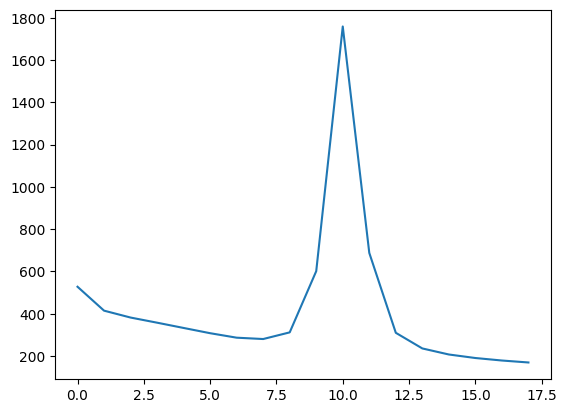

In [17]:
plt.plot(MSE_cv_linear_epoch[1:19])

In [18]:
# output of validation set
x_out_cv.shape

torch.Size([20, 10, 20])

In [19]:
# RMSE for training spikes : lastest epoch
np.sqrt(np.mean((spike_loss.detach() - y_training).numpy() ** 2)) 

19.996618